In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM,Dense, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential

Created By: Risky Novendri, Kota Jambi, Jambi

In [ ]:
used = ['datetime','temp']

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Dicoding Dataset/submission2.csv', usecols=used)
data

,datetime,temp
0,2011-01-01 00:00:00,9.84
1,2011-01-01 01:00:00,9.02
2,2011-01-01 02:00:00,9.02
3,2011-01-01 03:00:00,9.84
4,2011-01-01 04:00:00,9.84
...,...,...
10881,2012-12-19 19:00:00,15.58
10882,2012-12-19 20:00:00,14.76
10883,2012-12-19 21:00:00,13.94
10884,2012-12-19 22:00:00,13.94


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  10886 non-null  object 
 1   temp      10886 non-null  float64
dtypes: float64(1), object(1)
memory usage: 170.2+ KB


In [ ]:
data['datetime'] = pd.to_datetime(data['datetime'])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  10886 non-null  datetime64[ns]
 1   temp      10886 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 170.2 KB


In [ ]:
max = data['temp'].max()
min = data['temp'].min()
print(max)
print(min)

41.0
0.82


In [ ]:
mae = (max-min)*0.1
print(mae) #Calculation MAE Target

4.018


In [ ]:
x = data['datetime'].values
y = data['temp'].values

In [ ]:
print(type(y))

<class 'numpy.ndarray'>


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y, test_size=0.2)

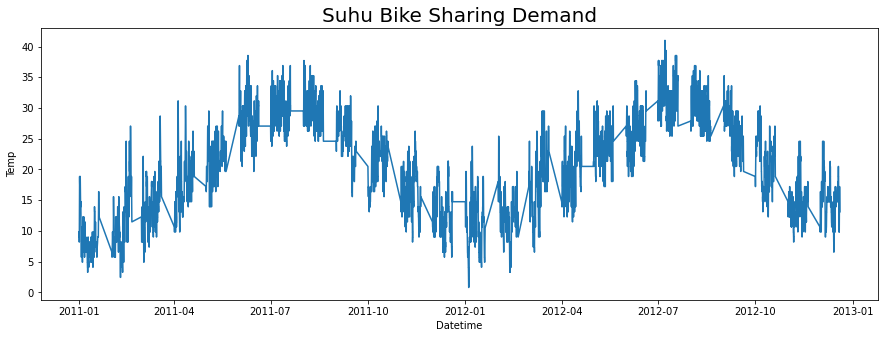

In [ ]:
#Visualize Dataset
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(x, y)
plt.ylabel('Temp')
plt.xlabel('Datetime')
plt.title('Suhu Bike Sharing Demand',
          fontsize=20);

In [ ]:
def windowed_dataset(series,window_size,batch_size,shuffle_buffer): #Create Window
  series = tf.expand_dims(series,axis=1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1 ,shift=1,drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [ ]:
train = windowed_dataset(ytrain,window_size=60,batch_size=100,shuffle_buffer=10000)
val = windowed_dataset(ytest,window_size=60,batch_size=100,shuffle_buffer=10000)

In [ ]:
model = Sequential([ #Create Model with LSTM
                    Bidirectional((LSTM(60,return_sequences= True))),
                    Bidirectional((LSTM(60,return_sequences= True))),
                    Dense(120, activation='relu'),
                    Dense(60, activation='relu'),
                    Dense(30, activation='relu'),
                    Dense(1)
                    ])

In [ ]:
optimizer = SGD(learning_rate=1.0000e-04, momentum=0.9) #Initialize Optimizer
losss = Huber()

In [ ]:
model.compile(optimizer=optimizer,loss=losss, metrics=["mae"])

In [ ]:
class myCallback(tf.keras.callbacks.Callback): #Create Callback
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<mae):
      print("\nRequirement Terpenuhi!,Mae < 10%")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
record = model.fit(train,epochs=100,verbose=2, callbacks=callbacks, validation_data=val) #Train Model

Epoch 1/100
87/87 - 87s - loss: 19.4504 - mae: 19.9502 - val_loss: 18.7529 - val_mae: 19.2529
Epoch 2/100
87/87 - 21s - loss: 18.4276 - mae: 18.9274 - val_loss: 17.1908 - val_mae: 17.6905
Epoch 3/100
87/87 - 21s - loss: 14.5336 - mae: 15.0303 - val_loss: 8.7696 - val_mae: 9.2547
Epoch 4/100
87/87 - 21s - loss: 6.5692 - mae: 7.0562 - val_loss: 6.2726 - val_mae: 6.7592
Epoch 5/100
87/87 - 21s - loss: 6.2134 - mae: 6.6998 - val_loss: 6.2521 - val_mae: 6.7389
Epoch 6/100
87/87 - 21s - loss: 6.1913 - mae: 6.6780 - val_loss: 6.2302 - val_mae: 6.7171
Epoch 7/100
87/87 - 21s - loss: 6.1679 - mae: 6.6546 - val_loss: 6.2053 - val_mae: 6.6923
Epoch 8/100
87/87 - 21s - loss: 6.1438 - mae: 6.6305 - val_loss: 6.1790 - val_mae: 6.6661
Epoch 9/100
87/87 - 21s - loss: 6.1178 - mae: 6.6046 - val_loss: 6.1527 - val_mae: 6.6399
Epoch 10/100
87/87 - 21s - loss: 6.0877 - mae: 6.5745 - val_loss: 6.1190 - val_mae: 6.6064
Epoch 11/100
87/87 - 21s - loss: 6.0514 - mae: 6.5382 - val_loss: 6.0799 - val_mae: 6.567

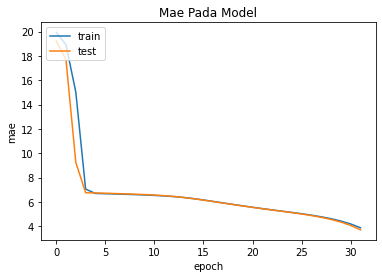

In [ ]:
#MAE Score Visualization
plt.plot(record.history['mae'])
plt.plot(record.history['val_mae'])
plt.title('Mae Pada Model')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

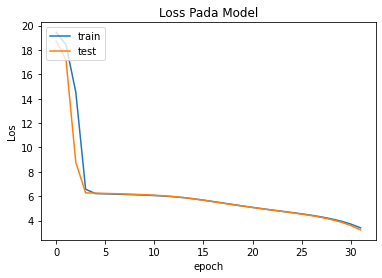

In [ ]:
#Loss Score
plt.plot(record.history['loss'])
plt.plot(record.history['val_loss'])
plt.title('Loss Pada Model')
plt.ylabel('Los')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()